<a href="https://colab.research.google.com/github/YANG-SOBER/Deep-Learning-for-Computer-Vision/blob/main/linear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 2-1: Linear Classifiers

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Guidong YANG

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['two_layer_net.ipynb', 'eecs598', 'two_layer_net.py', 'linear_classifier.py', 'linear_classifier.ipynb', 'a2_helpers.py']
```

In [ ]:
import os

#TODO: Fill in the Google Drive path where you uploaded the assignment
#Example: If you create a 2020FA folder and put all the files under A2 folder, then '2020FA/A2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2020FA/A2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL-Michigen/A2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['linear_classifier.ipynb', 'two_layer_net.ipynb', 'two_layer_net.py', 'a2_helpers.py', 'eecs598', '__pycache__', 'linear_classifier.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from linear_classifier.py!
```

as well as the last edit time for the file `linear_classifier.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from linear_classifier import hello_linear_classifier
hello_linear_classifier()

linear_classifier_path = os.path.join(GOOGLE_DRIVE_PATH, 'linear_classifier.py')
linear_classifier_edit_time = time.ctime(os.path.getmtime(linear_classifier_path))
print('linear_classifier.py last edited on %s' % linear_classifier_edit_time)

Hello from linear_classifier.py!
linear_classifier.py last edited on Sat Apr  2 02:36:53 2022


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
#import eecs598
#import torch
#import torchvision
#import matplotlib.pyplot as plt
#import statistics
#import random
#import time
#import math
#%matplotlib inline


#plt.rcParams['figure.figsize'] = (10.0, 8.0)
#plt.rcParams['font.size'] = 16

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [ ]:
import torch
torch.cuda.is_available()

True

## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset, same as knn. The utility function `eecs598.data.preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors**:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In this notebook we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

In the `two_layer_net.ipynb` notebook that follows this one, we will not use the bias trick.

We can learn more about the `eecs598.data.preprocess_cifar10` function by invoking the `help` command:

In [ ]:
import eecs598
help(eecs598.data.preprocess_cifar10)

Help on function preprocess_cifar10 in module eecs598.data:

preprocess_cifar10(cuda=True, show_examples=True, bias_trick=False, validation_ratio=0.2, dtype=torch.float32)
    Returns a preprocessed version of the CIFAR10 dataset, automatically
    downloading if necessary. We perform the following steps:
    
    (0) [Optional] Visualize some images from the dataset
    (1) Normalize the data by subtracting the mean
    (2) Reshape each image of shape (3, 32, 32) into a vector of shape (3072,)
    (3) [Optional] Bias trick: add an extra dimension of ones to the data
    (4) Carve out a validation set from the training set
    
    Inputs:
    - cuda: If true, move the entire dataset to the GPU
    - validation_ratio: Float in the range (0, 1) giving the fraction of the train
      set to reserve for validation
    - bias_trick: Boolean telling whether or not to apply the bias trick
    - show_examples: Boolean telling whether or not to visualize data samples
    - dtype: Optional, dat

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = [10.0, 8.0]

In [ ]:
def _extract_tensors(dset, num=None):

  """
  Extract data and targets from the torchvision.datasets.CIFAR10 object.

  Input:
    - dset: torchvision.datasets.CIFAR10 object
    - num: num of data samples needed.
  
  Output:
    - x: data samples
    - y: target samples

  """

  x = torch.tensor(dset.data, dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  y = torch.tensor(dset.targets, dtype=torch.int64)
  if num is not None:
    if num < 0 or num > x.shape[0]:
      raise ValueError(f"Invalid value; num should be in the range of [0, {x.shape[0]}]")
    else:
      x = x[:num].clone()
      y = y[:num].clone()
  
  return x, y

In [ ]:
def cifar10(num_train=None, num_test=None):

  """
  Download the cifar10 dataset and extract training set and test set.

  Input:
  - num_train: the number of training samples
  - num_test: the number of test samples

  Output:
  - x_train: torch.Tensor object, shape: (N_train, C, H, W) dtype: torch.float32
  - x_test: torch.Tensor object, shape: (N_test, C, W, W) dtype: torch.float32
  - y_train: torch.Tensor object, shape: (N_train,) dtype: torch.int64
  - y_test: torch.Tensor object, shape: (N_test,) dtype: torch.int64
  
  """

  download = not os.path.isdir("cifar-10-batches-py")
  train_set = torchvision.datasets.CIFAR10(root='.', train=True, download=download)
  test_set = torchvision.datasets.CIFAR10(root='.', train=False, download=False)
  x_train, y_train = _extract_tensors(train_set, num=num_train)
  x_test, y_test = _extract_tensors(test_set, num=num_test)

  return train_set, x_train, x_test, y_train, y_test

In [ ]:
def preprocess_cifar10(cuda=True, show_examples=True, bias_trick=False, validation_ratio=0.2, dtype=torch.float32):

  # data on the CPU
  train_set, x_train, x_test, y_train, y_test = cifar10()

  # transfer data to the GPU
  if cuda:
    x_train = x_train.cuda()
    x_test = x_test.cuda()
    y_train = y_train.cuda()
    y_test = y_test.cuda()

  # visualize the images from the dataset
  if show_examples:
    classes = train_set.classes # a list storing class names of CIFAR10
    samples_per_class = 12 # the number of images visualized per class
    imgs_list = [] # stores images to be visualized
    random.seed(0)
    for yi, cls in enumerate(classes):
      plt.text(-4, 34*yi+18, cls, ha='right')
      idxs, = (y_train.eq(yi)).nonzero(as_tuple=True) # return the idx corresponding to the class yi
      for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item() # randomly pick one correct index for class yi
        img = x_train[idx]  # return the image
        imgs_list.append(img)
    img_grid = torchvision.utils.make_grid(imgs_list, nrow=samples_per_class, padding=3, pad_value=1)
    img_grid = img_grid.mul(255).add(0.5).clamp(0, 255).to(dtype=torch.uint8, device='cpu').permute(1, 2, 0)
    plt.imshow(img_grid)
    plt.axis('off')
  
  # Normalizing the data by subtracting the mean
  x_train_mean = x_train.mean(dim=(0, 2, 3), keepdim=True)
  x_train = x_train - x_train_mean
  x_test = x_test - x_train_mean

  # reshape each image of (3, 32, 32) into the shape of (3072,)
  x_train = x_train.view(x_train.shape[0], -1)
  x_test = x_test.view(x_test.shape[0], -1)

  # Bias trick
  if bias_trick:
    train_ones = torch.ones((x_train.shape[0], 1), dtype=dtype, device=x_train.device)
    x_train = torch.cat((x_train, train_ones), dim=1)
    test_ones = torch.ones((x_test.shape[0], 1), dtype=dtype, device=x_test.device)
    x_test = torch.cat((x_test, test_ones), dim=1)
  
  # Carve out a validation set from the training set
  num_train = int(x_train.shape[0] * (1 - validation_ratio))
  num_val = x_train.shape[0] - num_train

  data_dict={}
  data_dict["X_train"] = x_train[:num_train]
  data_dict["X_val"] = x_train[num_train:num_train + num_val]
  data_dict["X_test"] = x_test
  data_dict["y_train"] = y_train[:num_train]
  data_dict["y_val"] = y_train[num_train:num_train + num_val]
  data_dict["y_test"] = y_test
  
  return data_dict # a dictionary





We can now run the `eecs598.data.preprocess` function to get our data:

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Train data shape:  torch.Size([40000, 3073])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3073])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


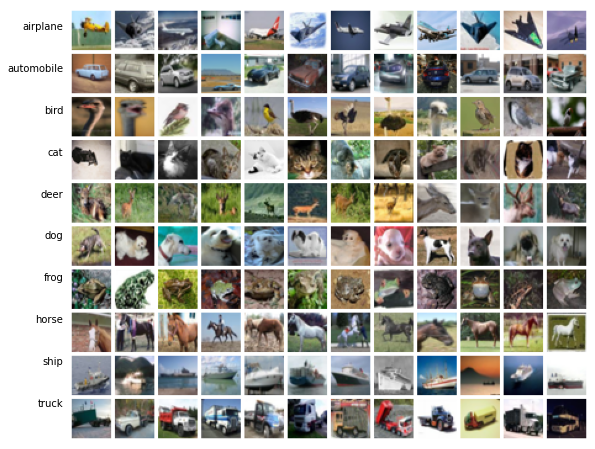

In [ ]:
data_dict = preprocess_cifar10(bias_trick=True, cuda=True, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

In [ ]:
data_dict["X_train"].device, data_dict["X_val"].device

(device(type='cuda', index=0), device(type='cuda', index=0))

# SVM Classifier

In this section, you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In Assignment 2, you SHOULD NOT use ".to()" or ".cuda()" in each implementation block. Otherwise, your implementation would gives you an error in Autograder end.

First, we will test the naive version of svm loss in `linear_classifier.py`. Let's first try the naive implementation of the loss we provided for you. You will get 9.000197. (Note: we've provided the `loss` part of the `svm_loss_naive` function, so you don't need to re-implement in `svm_loss_naive`. However, if your loss value doesn't match, then please report this to [Piazza](https://piazza.com/class/ke3a8m6u5wx647))

In [ ]:
from linear_classifier import svm_loss_naive
help(svm_loss_naive)

Help on function svm_loss_naive in module linear_classifier:

svm_loss_naive(W, X, y, reg)
    Structured SVM loss function, naive implementation (with loops).
    
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples. When you implment the regularization over W, please DO NOT
    multiply the regularization term by 1/2 (no coefficient).
    
    Inputs:
    - W: A PyTorch tensor of shape (D, C) containing weights.
    - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
    - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength
    
    Returns a tuple of:
    - loss as torch scalar
    - gradient of loss with respect to weights W; a tensor of same shape as W



In [ ]:
def svm_loss_naive(W, X, y, reg):
  """
  Input:
  - W: A PyTorch tensor of shape (D, C) containing weights
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data
  - y: A PyTorch tensor of shape (N,) containing training labels: y[i]=c means X[i] has label c, where 0 <= c < C
  - reg: regularization strength (float)
  """
  loss = 0.0
  dW = torch.zeros_like(W)
  num_train = X.shape[0]
  num_class = W.shape[1]

  for i in range(num_train):
    s = W.t().matmul(X[i]) # predicted score of sample i, torch.Tensor shape: (C,)
    yi = y[i] # ground-truth score of sample i, torch.Tensor shape: (,)
    for j in range(num_class):
      if j == yi:
        continue
      s_yi = s[yi]
      s_j = s[j]
      margin = s_j - s_yi + 1
      if margin > 0:
        loss += margin
        dW[:, j] += X[i]
        dW[:, y[i]] -= X[i]

  loss /= num_train # total loss over the whole dataset
  loss += reg * torch.linalg.norm(W, ord='fro').square() # torch.sum(W**2)
  dW /= num_train
  dW += 2 * reg * W

  return loss, dW

In [ ]:
import eecs598

torch.manual_seed(0)
# generate a random SVM weight tensor of small numbers
W = torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device) * 0.0001 

loss, _grad_ = svm_loss_naive(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

loss: 9.000888


The `_grad_` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`, by filing out the TODO blocks. You will find it helpful to interleave your new code inside the existing function.

To check that you have implemented the gradient correctly, we will use **numeric gradient checking**: we will use a finite differences approach to numerically estimate the gradient of the forward pass, and compare this numeric gradient to the analytic gradient that you implemented.

We have provided a function `eecs598.grad.grad_check_sparse` to help with numeric gradient checking. You can learn more about this function using the `help` command:

In [ ]:
import eecs598
help(eecs598.grad.grad_check_sparse)

Help on function grad_check_sparse in module eecs598.grad:

grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-07)
    Utility function to perform numeric gradient checking. We use the centered
    difference formula to compute a numeric derivative:
    
    f'(x) =~ (f(x + h) - f(x - h)) / (2h)
    
    Rather than computing a full numeric gradient, we sparsely sample a few
    dimensions along which to compute numeric derivatives.
    
    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor giving the point at which to evaluate the numeric gradient
    - analytic_grad: A torch tensor giving the analytic gradient of f at x
    - num_checks: The number of dimensions along which to check
    - h: Step size for computing numeric derivatives



Now run the following to perform numeric gradient checking on the gradients of your SVM loss. You should see relative errors less than `1e-5`.

In [ ]:
import eecs598

# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
# YOUR_TURN: implement the gradient part of 'svm_loss_naive' function in "linear_classifier.py"
_, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = eecs598.grad.grad_check_sparse(f, W.double(), grad)

numerical: 0.031599 analytic: 0.031599, relative error: 8.135595e-08
numerical: 0.111444 analytic: 0.111444, relative error: 2.755349e-09
numerical: 0.011204 analytic: 0.011204, relative error: 3.158812e-07
numerical: -0.046128 analytic: -0.046128, relative error: 1.076065e-07
numerical: 0.071948 analytic: 0.071948, relative error: 1.387499e-08
numerical: 0.025688 analytic: 0.025688, relative error: 3.030575e-07
numerical: 0.185388 analytic: 0.185388, relative error: 2.321589e-08
numerical: -0.021740 analytic: -0.021740, relative error: 8.965965e-07
numerical: -0.159613 analytic: -0.159613, relative error: 8.942929e-08
numerical: 0.092690 analytic: 0.092690, relative error: 5.943716e-08


Let's do the gradient check once again with regularization turned on. (You didn't forget the regularization gradient, did you?)

You should see relative errors less than `1e-5`.

In [ ]:
import eecs598

# Use a minibatch of data from the val set for gradient checking
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
# YOUR_TURN: check your 'svm_loss_naive' implementation with different 'reg'
_, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=1e3) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = eecs598.grad.grad_check_sparse(f, W.double(), grad)

numerical: 0.124849 analytic: 0.124849, relative error: 3.752756e-08
numerical: 0.168915 analytic: 0.168915, relative error: 8.428526e-09
numerical: 0.148752 analytic: 0.148752, relative error: 3.557334e-08
numerical: -0.024936 analytic: -0.024936, relative error: 1.128618e-07
numerical: -0.008570 analytic: -0.008570, relative error: 5.655113e-09
numerical: -0.103155 analytic: -0.103155, relative error: 6.353446e-08
numerical: -0.335573 analytic: -0.335573, relative error: 1.224207e-08
numerical: -0.222176 analytic: -0.222176, relative error: 9.741194e-08
numerical: 0.681163 analytic: 0.681163, relative error: 1.711659e-08
numerical: -0.004089 analytic: -0.004089, relative error: 2.068229e-06


Now, let's implement vectorized version of SVM: `svm_loss_vectorized`. It should compute the same inputs and outputs as the naive version before, but it should involve **no explicit loops**.

Let's first check the speed and performance bewteen the non-vectorized and the vectorized version. You should see a 15-120x speedup. PyTorch does some extra setup the first time you run CUDA code, so **you may need to run this cell more than once to see the desired speedup**.

(Note: It may have some difference, but should be less than 1e-6)

In [ ]:
def svm_loss_vectorized(W, X, y, reg):

    """
    Structured SVM loss function, vectorized implementation.
    When you implement the regularization over W, please DO NOT multiply the regularization
    term by 1/2 (no coefficient). The inputs and outputs are the same as svm_loss_naive.

    Inputs:
    - W: A PyTorch tensor of shape (D, C) containing weights.
    - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
    - y: A PyTorch tensor of shape (N,) containing training labels;
        - y[i] = c means that X[i] has label c, where  0 <= c < C.
    - reg: (float) regularization strength
    
    Returns a tuple of:
    - loss as torch scalar
    - gradient of loss w.r.t weights W; a tensor of same shape as W

    """
    # initialization loss, dW
    loss = 0.0
    dW = torch.zeros_like(W)
    
    num_train = X.shape[0]
    num_class = W.shape[1]

    # data loss
    s = X.matmul(W) # (N, C) predicted label
    s_yi = s[torch.arange(s.shape[0]), y] # (N,) ground-truth label
    s_yi = s_yi.view(-1, 1) # (N, 1)
    margin = s - s_yi + 1 # (N, C)
    margin[torch.arange(s.shape[0]), y] = 0 # Let the score for the correct class to be zero
    margin[margin < 0] = 0 # max(0, x) operation
    loss_matrix = torch.sum(margin, dim=1, keepdim=True) # (N,) stores loss for each sample
    loss += loss_matrix.sum()
    loss /= num_train
    
    # regularization term
    loss += reg * torch.linalg.norm(W, ord='fro').square()
    
    # compute gradient
    margin[margin > 0] = 1
    margin[torch.arange(s.shape[0]), y] = -9
    
    dW = X.t().matmul(margin) # (D, C)
    dW /= num_train
    
    dW += 2 * reg * W
    
    return loss, dW

In [ ]:
import eecs598

# Use a minibatch of data from the val set for gradient checking
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
# YOUR_TURN: check your 'svm_loss_naive' implementation with different 'reg'
_, grad = svm_loss_vectorized(W.double(), X_batch, y_batch, reg=1e3) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_vectorized(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = eecs598.grad.grad_check_sparse(f, W.double(), grad)

numerical: 0.124849 analytic: 0.124849, relative error: 3.752756e-08
numerical: 0.168915 analytic: 0.168915, relative error: 4.415297e-08
numerical: 0.148752 analytic: 0.148752, relative error: 5.719000e-09
numerical: -0.024936 analytic: -0.024936, relative error: 6.522796e-08
numerical: -0.008570 analytic: -0.008570, relative error: 5.238159e-07
numerical: -0.103155 analytic: -0.103155, relative error: 6.561804e-08
numerical: -0.335573 analytic: -0.335573, relative error: 1.224207e-08
numerical: -0.222176 analytic: -0.222176, relative error: 1.745925e-08
numerical: 0.681163 analytic: 0.681163, relative error: 2.442131e-09
numerical: -0.004089 analytic: -0.004089, relative error: 9.822957e-07


In [ ]:
import eecs598
import time
#from linear_classifier import svm_loss_naive, svm_loss_vectorized

# Use random weights and a minibatch of val data for gradient checking
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
# YOUR_TURN: implement the loss part of 'svm_loss_vectorized' function in "linear_classifier.py"
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))

# The losses should match but your vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss: 9.002394e+00 computed in 152.60ms
Vectorized loss: 9.002394e+00 computed in 0.75ms
Difference: -1.60e-14
Speedup: 202.23X


Then, let's compute the gradient of the loss function. We can check the difference of gradient as well. (The error should be less than 1e-6)

Now implement a vectorized version of the gradient computation in `svm_loss_vectorize` above. Run the cell below to compare the gradient of your naive and vectorized implementations. The difference between the gradients should be less than `1e-6`, and the vectorized version should run 15-120x faster.


In [ ]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

import eecs598
#from linear_classifier import svm_loss_naive, svm_loss_vectorized

# Use random weights and a minibatch of val data for gradient checking
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
# YOUR_TURN: implement the gradient part of 'svm_loss_vectorized' function in "linear_classifier.py"
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# we use the Frobenius norm to compare them.
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.20e' % grad_difference)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss and gradient: computed in 154.13ms
Vectorized loss and gradient: computed in 0.71ms
Gradient difference: 0.00000000000000000000e+00
Speedup: 215.63X


In [ ]:
grad_vec

tensor([[-0.0513, -0.0013,  0.0836,  ...,  0.0914,  0.0117, -0.3603],
        [-0.0554, -0.0097,  0.0642,  ...,  0.0854,  0.0134, -0.3436],
        [-0.0596, -0.0269,  0.0530,  ...,  0.0767,  0.0158, -0.3409],
        ...,
        [-0.0633,  0.0553, -0.0258,  ..., -0.0437,  0.0998, -0.1889],
        [-0.0783,  0.0556,  0.0024,  ..., -0.0235,  0.0768, -0.2153],
        [ 0.5313, -0.0938,  0.1406,  ..., -0.1719,  0.0625, -0.6406]],
       device='cuda:0', dtype=torch.float64)

Now that we have an efficient vectorized implementation of the SVM loss and its gradient, we can implement a training pipeline for linear classifiers.

Please complete the implementation of `train_linear_classifier` in `linear_classifer.py`.


Once you have implemented the training function, run the following cell to train a linear classifier using some default hyperparameters:

(You should see a final loss close to 9.0, and your training loop should run in about two seconds)

In [ ]:
def sample_batch(X, y, num_train, batch_size):
    """
    Sample batch_size elements from the training data and their
    corresponding labels to use in this round of gradient descent.
    """
    X_batch = None
    y_batch = None
    #########################################################################
    # TODO: Store the data in X_batch and their corresponding labels in     #
    # y_batch; after sampling, X_batch should have shape (batch_size, dim)  #
    # and y_batch should have shape (batch_size,)                           #
    #                                                                       #
    # Hint: Use torch.randint to generate indices.                          #
    #########################################################################
    # Replace "pass" statement with your code
    idx = torch.randint(num_train, size=(batch_size,))
    X_batch = X[idx]
    y_batch = y[idx]
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################
    return X_batch, y_batch


def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3,
                            reg=1e-5, num_iters=100, batch_size=200,
                            verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - loss_func: loss function to use when training. It should take W, X, y
    and reg as input, and output a tuple of (loss, dW)
    - W: A PyTorch tensor of shape (D, C) giving the initial weights of the
    classifier. If W is None then it will be initialized here.
    - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.
    - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c
    means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Returns: A tuple of:
    - W: The final value of the weight matrix and the end of optimization
    - loss_history: A list of Python scalars giving the values of the loss at each
    training iteration.
    """
    # assume y takes values 0...K-1 where K is number of classes
    num_train, dim = X.shape
    if W is None:
    # lazily initialize W
        num_classes = torch.max(y) + 1
        W = 0.001 * torch.randn(dim, num_classes, device=X.device, dtype=X.dtype)
    else:
        num_classes = W.shape[1]

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
        # TODO: implement sample_batch function
        X_batch, y_batch = sample_batch(X, y, num_train, batch_size)
        #print(X_batch.shape)
        #print(y_batch.shape)

        # evaluate loss and gradient
        loss, grad = loss_func(W, X_batch, y_batch, reg)
        loss_history.append(loss.item())

        # perform parameter update
        #########################################################################
        # TODO:                                                                 #
        # Update the weights using the gradient and the learning rate.          #
        #########################################################################
        # Replace "pass" statement with your code
        W -= learning_rate * grad
        #########################################################################
        #                       END OF YOUR CODE                                #
        #########################################################################

        if verbose and it % 100 == 0:
            print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return W, loss_history

In [ ]:
torch.manual_seed(0)

torch.cuda.synchronize()
tic = time.time()

# YOUR_TURN: Implement how to construct the batch, 
#            and how to update the weight in 'train_linear_classifier'
W, loss_hist = train_linear_classifier(svm_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-7, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 778.135533
iteration 100 / 1500: loss 291.227868
iteration 200 / 1500: loss 112.569164
iteration 300 / 1500: loss 47.002436
iteration 400 / 1500: loss 22.945549
iteration 500 / 1500: loss 14.116644
iteration 600 / 1500: loss 10.876893
iteration 700 / 1500: loss 9.687449
iteration 800 / 1500: loss 9.251269
iteration 900 / 1500: loss 9.091063
iteration 1000 / 1500: loss 9.032488
iteration 1100 / 1500: loss 9.011145
iteration 1200 / 1500: loss 9.003231
iteration 1300 / 1500: loss 9.000184
iteration 1400 / 1500: loss 8.999561
That took 1.030549s


A useful debugging strategy is to plot the loss as a function of iteration number. In this case it seems our hyperparameters are not good, since the training loss is not decreasing very fast.



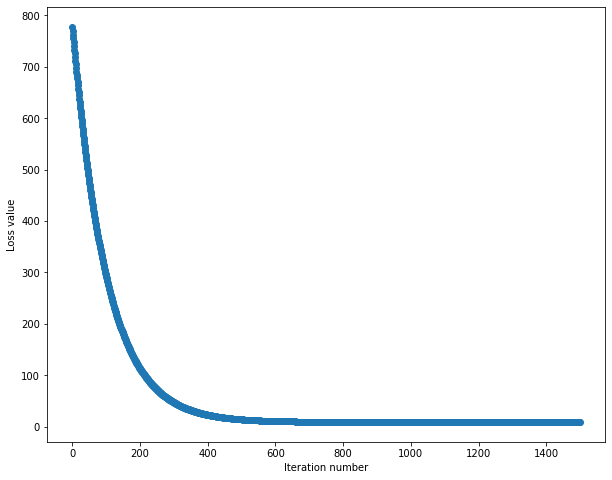

In [ ]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Then, let's move on to the prediction stage. We can evaluate the performance our trained model on both the training and validation set. You should see validation accuracy less than 20%.

In [ ]:
def predict_linear_classifier(W, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - W: A PyTorch tensor of shape (D, C), containing weights of a model
    - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.

    Returns:
    - y_pred: PyTorch int64 tensor of shape (N,) giving predicted labels for each
    elemment of X. Each element of y_pred should be between 0 and C - 1.
    """
    y_pred = torch.zeros(X.shape[0], dtype=torch.int64) 
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    # Replace "pass" statement with your code
    y_pred = torch.max(X.matmul(W), dim=1)[1]
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred


In [ ]:
# fix random seed before we perform this operation
eecs598.reset_seed(0)

# evaluate the performance on both the training and validation set
# YOUR_TURN: Implement how to make a prediction with the trained weight 
#            in 'predict_linear_classifier'
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('Training accuracy: %.2f%%' % train_acc)

y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 24.73%
Validation accuracy: 24.76%


Unfortunately, the performance of our initial model is quite bad. To find a better hyperparamters, we first modulized the functions that we've implemented as LinearSVM.

Now, please use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment your best model found through cross-validation should achieve an accuracy of at least 37% on the validation set.

(Our best model got over 38.1% -- did you beat us?)

In [ ]:
def svm_get_search_params():
    """
    Return candidate hyperparameters for the SVM model. You should provide
    at least two param for each, and total grid search combinations
    should be less than 25.

    Returns:
    - learning_rates: learning rate candidates, e.g. [1e-3, 1e-2, ...]
    - regularization_strengths: regularization strengths candidates
                              e.g. [1e0, 1e1, ...]
    """

    learning_rates = []
    regularization_strengths = []

    ###########################################################################
    # TODO:   add your own hyper parameter lists.                             #
    ###########################################################################
    # Replace "pass" statement with your code
    learning_rates = [1e-8, 1e-7, 1e-6, 1e-4]
    regularization_strengths = [2.5e1, 2.5e2, 2.5e3, 2.5e4]
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################

    return learning_rates, regularization_strengths


def test_one_param_set(cls, data_dict, lr, reg, num_iters=2000):
    """
    Train a single LinearClassifier instance and return the learned instance
    with train/val accuracy.

    Inputs:
    - cls (LinearClassifier): a newly-created LinearClassifier instance.
                            Train/Validation should perform over this instance
    - data_dict (dict): a dictionary that includes
                      ['X_train', 'y_train', 'X_val', 'y_val']
                      as the keys for training a classifier
    - lr (float): learning rate parameter for training a SVM instance.
    - reg (float): a regularization weight for training a SVM instance.
    - num_iters (int, optional): a number of iterations to train

    Returns:
    - cls (LinearClassifier): a trained LinearClassifier instances with
                            (['X_train', 'y_train'], lr, reg)
                            for num_iter times.
    - train_acc (float): training accuracy of the svm_model
    - val_acc (float): validation accuracy of the svm_model
    """
    train_acc = 0.0 # The accuracy is simply the fraction of data points
    val_acc = 0.0   # that are correctly classified.
    ###########################################################################
    # TODO:                                                                   #
    # Write code that, train a linear SVM on the training set, compute its    #
    # accuracy on the training and validation sets                            #
    #                                                                         #
    # Hint: Once you are confident that your validation code works, you       #
    # should rerun the validation code with the final value for num_iters.    #
    # Before that, please test with small num_iters first                     #
    ###########################################################################
    # Feel free to uncomment this, at the very beginning,
    # and don't forget to remove this line before submitting your final version
    #num_iters = 100
    loss_history = cls.train(data_dict["X_train"], data_dict["y_train"], lr, reg, num_iters)
    y_pred_train = cls.predict(data_dict["X_train"])
    y_train = data_dict["y_train"]
    y_pred_val = cls.predict(data_dict["X_val"])
    y_val = data_dict["y_val"]
    
    train_acc = 100 * (y_train == y_pred_train).double().mean().item()
    val_acc = 100 * (y_val == y_pred_val).double().mean().item()
    
    # Replace "pass" statement with your code
    
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################

    return cls, train_acc, val_acc

In [ ]:
from abc import ABCMeta, abstractmethod
# Template class modules that we will use later: Do not edit/modify this class
class LinearClassifier(object):
    """ An abstarct class for the linear classifiers """
    # Note: We will re-use `LinearClassifier' in both SVM and Softmax
    def __init__(self):
        random.seed(0)
        torch.manual_seed(0)
        self.W = None

    def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100, 
              batch_size=200, verbose=False):
        train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg, 
                      num_iters, batch_size, verbose)
        self.W, loss_history = train_linear_classifier(*train_args)
        return loss_history

    def predict(self, X):
        return predict_linear_classifier(self.W, X)

    @abstractmethod
    def loss(self, W, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
        - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an tensor of the same shape as W
        """
        raise NotImplementedError

    def _loss(self, X_batch, y_batch, reg):
        self.loss(self.W, X_batch, y_batch, reg)

    def save(self, path):
        torch.save({'W': self.W}, path)
        print("Saved in {}".format(path))

    def load(self, path):
        W_dict = torch.load(path, map_location='cpu')
        self.W = W_dict['W']
        print("load checkpoint file: {}".format(path))



class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """
    def loss(self, W, X_batch, y_batch, reg):
        return svm_loss_vectorized(W, X_batch, y_batch, reg)

In [ ]:
import os
import eecs598

# YOUR_TURN: find the best learning_rates and regularization_strengths combination
#            in 'svm_get_search_params'
learning_rates, regularization_strengths = svm_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

####
# It is okay to comment out the following conditions when you are working on svm_get_search_params.
# But, please do not forget to reset back to the original setting once you are done.
if num_models > 25:
    raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
    raise Exception("Please present at least 5 parameter sets in your final ipynb")
####


i = 0
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (train_acc, val_acc). 
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_svm_model = None # The LinearSVM object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
    for reg in regularization_strengths:
        i += 1
        print('Training SVM %d / %d with learning_rate=%e and reg=%e'
              % (i, num_models, lr, reg))
    
        eecs598.reset_seed(0)
        # YOUR_TURN: implement a function that gives the trained model with 
        #            train/validation accuracies in 'test_one_param_set'
        #            (note: this function will be used in Softmax Classifier section as well)
        cand_svm_model, cand_train_acc, cand_val_acc = test_one_param_set(LinearSVM(), data_dict, lr, reg, num_iters)

        if cand_val_acc > best_val:
            best_val = cand_val_acc
            best_svm_model = cand_svm_model # save the svm
            results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
    train_acc, val_acc = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# save the best model
path = os.path.join('svm_best_model.pt')
best_svm_model.save(path)

Training SVM 1 / 16 with learning_rate=1.000000e-08 and reg=2.500000e+01
Training SVM 2 / 16 with learning_rate=1.000000e-08 and reg=2.500000e+02
Training SVM 3 / 16 with learning_rate=1.000000e-08 and reg=2.500000e+03
Training SVM 4 / 16 with learning_rate=1.000000e-08 and reg=2.500000e+04
Training SVM 5 / 16 with learning_rate=1.000000e-07 and reg=2.500000e+01
Training SVM 6 / 16 with learning_rate=1.000000e-07 and reg=2.500000e+02
Training SVM 7 / 16 with learning_rate=1.000000e-07 and reg=2.500000e+03
Training SVM 8 / 16 with learning_rate=1.000000e-07 and reg=2.500000e+04
Training SVM 9 / 16 with learning_rate=1.000000e-06 and reg=2.500000e+01
Training SVM 10 / 16 with learning_rate=1.000000e-06 and reg=2.500000e+02
Training SVM 11 / 16 with learning_rate=1.000000e-06 and reg=2.500000e+03
Training SVM 12 / 16 with learning_rate=1.000000e-06 and reg=2.500000e+04
Training SVM 13 / 16 with learning_rate=1.000000e-04 and reg=2.500000e+01
Training SVM 14 / 16 with learning_rate=1.00000

Visualize the cross-validation results. You can use this as a debugging tool -- after examining the cross-validation results here, you may want to go back and rerun your cross-validation from above.

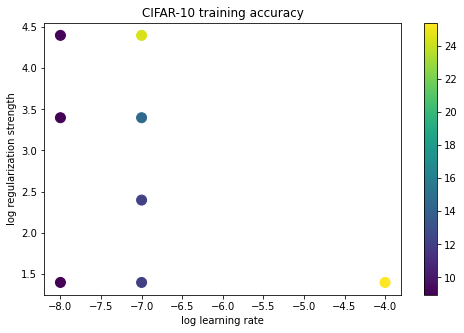

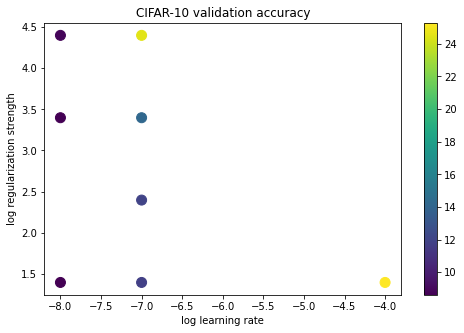

In [ ]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Evaluate the best svm on test set. To get full credit for the assignment you should achieve a test-set accuracy above 35%.

(Our best was over 39.1% -- did you beat us?)

In [ ]:
import eecs598

eecs598.reset_seed(0)
y_test_pred = best_svm_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.259500


Visualize the learned weights for each class. Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

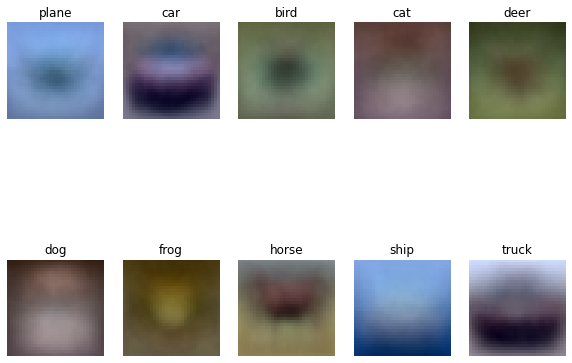

In [ ]:
w = best_svm_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.type(torch.uint8).cpu())
    plt.axis('off')
    plt.title(classes[i])

# Softmax Classifier

Similar to the SVM, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

As noted in the SVM section, you SHOULD NOT use ".to()" or ".cuda()" in each implementation block.

First, let's start from implementing the naive softmax loss function with nested loops in `softmax_loss_naive` function.

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. You should see loss near log(10) = 2.3

In [ ]:
def softmax_loss_naive(W, X, y, reg):

  """
  Softmax loss function, naive implementation (with loops).
  When you implement the regularization over W, please
  DO NOT multiply the regularization term by 1/2 (no coefficient).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels;
  y[i] == c means X[i] has label c, where  0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an tensor of same shape as W
  
  """

  # Initialize loss and dW
  loss = 0.0
  dW = torch.zeros_like(W)
  num_classes = W.shape[1]
  num_samples = X.shape[0]

  # Compute loss
  # Data loss
  for i in range(X.shape[0]):
    z = torch.mv(W.t(), X[i]) # (C,)
    z -= z.max() # Shift the values inside s so that the highest value is zero
    s = torch.exp(z) / torch.exp(z).sum()
    loss -= torch.log(s[y[i]]) # data_loss

    y_t = torch.zeros_like(s).to(dtype=torch.int64)
    y_t[y[i]] = 1
    dW += torch.mm(X[i].unsqueeze(1), (s-y_t).unsqueeze(0))

  loss /= num_samples
  dW /= num_samples

  # Regularization
  loss += reg * torch.linalg.norm(W, ord='fro').square()
  dW += 2 * reg * W
    

  return loss, dW



In [ ]:
data_dict['X_val'].dtype, data_dict['X_val'].device

(torch.float64, device(type='cuda', index=0))

In [ ]:
import math

W = 0.00001 * torch.randn((3073, 10), dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

loss, _ = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

print("loss: {}".format(loss))
print("sanity check: {}".format(math.log(10)))

loss: 2.302588050432787
sanity check: 2.302585092994046


Next, we use gradient checking to debug the analytic gradient of our naive softmax loss function. If you've implemented the gradient correctly, you should see relative errors less than `1e-5`.


In [ ]:
import eecs598
#from linear_classifier import softmax_loss_naive

eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the implementation of softmax_loss_naive and implement 
# a (naive) version of the gradient that uses nested loops.
_, grad = softmax_loss_naive(W.double(), X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
eecs598.grad.grad_check_sparse(f, W.double(), grad, 10)

numerical: 0.003050 analytic: 0.003050, relative error: 3.029820e-07
numerical: 0.006309 analytic: 0.006309, relative error: 6.107012e-08
numerical: 0.005396 analytic: 0.005396, relative error: 8.877772e-07
numerical: 0.002573 analytic: 0.002573, relative error: 4.210145e-07
numerical: 0.007509 analytic: 0.007509, relative error: 1.368565e-07
numerical: 0.006418 analytic: 0.006418, relative error: 7.677905e-07
numerical: 0.011393 analytic: 0.011393, relative error: 1.619217e-07
numerical: 0.001822 analytic: 0.001822, relative error: 1.382408e-06
numerical: -0.014710 analytic: -0.014710, relative error: 7.515623e-08
numerical: -0.005155 analytic: -0.005155, relative error: 1.706017e-07


In [ ]:
torch.manual_seed(128)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=10.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=10.0)[0]
eecs598.grad.grad_check_sparse(f, W, grad, 10)

numerical: 0.004914 analytic: 0.004914, relative error: 1.381561e-07
numerical: 0.005888 analytic: 0.005888, relative error: 4.761607e-07
numerical: 0.006301 analytic: 0.006301, relative error: 8.823149e-07
numerical: 0.001577 analytic: 0.001577, relative error: 2.704551e-07
numerical: 0.005843 analytic: 0.005843, relative error: 2.494620e-07
numerical: 0.006796 analytic: 0.006796, relative error: 3.048356e-07
numerical: 0.011460 analytic: 0.011460, relative error: 2.962282e-08
numerical: 0.002312 analytic: 0.002312, relative error: 9.954670e-07
numerical: -0.016806 analytic: -0.016806, relative error: 9.507768e-08
numerical: -0.006676 analytic: -0.006676, relative error: 1.157829e-06


Let's perform another gradient check with regularization enabled. Again you should see relative errors less than `1e-5`.

In [ ]:
import eecs598
#from linear_classifier import softmax_loss_naive

eecs598.reset_seed(128)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 10.0

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the gradient compuation part of softmax_loss_naive 
_, grad = softmax_loss_naive(W.double(), X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
eecs598.grad.grad_check_sparse(f, W.double(), grad, 10)

numerical: 0.004914 analytic: 0.004914, relative error: 1.381561e-07
numerical: 0.005888 analytic: 0.005888, relative error: 4.761607e-07
numerical: 0.006301 analytic: 0.006301, relative error: 8.823149e-07
numerical: 0.001577 analytic: 0.001577, relative error: 2.704551e-07
numerical: 0.005843 analytic: 0.005843, relative error: 2.494620e-07
numerical: 0.006796 analytic: 0.006796, relative error: 3.048356e-07
numerical: 0.011460 analytic: 0.011460, relative error: 2.962282e-08
numerical: 0.002312 analytic: 0.002312, relative error: 9.954670e-07
numerical: -0.016806 analytic: -0.016806, relative error: 9.507768e-08
numerical: -0.006676 analytic: -0.006676, relative error: 1.157829e-06


Then, let's move on to the vectorized form: `softmax_loss_vectorized`.

Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.

The differences between the naive and vectorized losses and gradients should both be less than `1e-6`, and your vectorized implementation should be at least 20x faster than the naive implementation.

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.
  When you implement the regularization over W, 
  please DO NOT multiply the regularization term by 1/2 (no coefficient).

  Inputs and outputs are the same as softmax_loss_naive.

  Input:
  - W: (D, C)  weight matrix of the linear classifier
  - X: (N, D)  input
  - y: (N, )  label
  - reg: float  the regularization strength

  """

  # initialize the loss and gradient of the weight
  loss = 0.0
  dW = torch.zeros_like(W)
  num_classes = W.shape[1]
  num_samples = X.shape[0]

  # compute loss without explicit loops
  z = torch.mm(X, W) # (N, C) (with bias trick, thus no explicit bias here.
  z -= z.max(dim=1, keepdim=True)[0] # for numerical stability
  s = torch.exp(z) / torch.exp(z).sum(dim=1, keepdim=True) # (N, C)
  s_yi = s[torch.arange(num_samples), y] # (N, ) storing the predicted probabilities
  loss -= torch.log(s_yi).sum() # 

  loss /= num_samples
  loss += 2 * reg * torch.linalg.norm(W, ord='fro')

  # compute gradient without explicit loops
  y_t = torch.zeros_like(s) # (N, C)
  y_t[torch.arange(num_samples), y] = 1

  dz = s - y_t # (N, C)
  dW += torch.mm(X.t(), dz) # (D, C)
  dW /= num_samples
  dW += 2 * reg * W

  return loss, dW

In [ ]:
torch.manual_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

reg = 0.05

# Use naive implementation to compute Cross-Entropy Loss
torch.cuda.synchronize()
tic = time.time()

loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)

torch.cuda.synchronize()
toc = time.time()
time_naive = toc - tic

# Use vectorized implementation to compute Cross-Entropy Loss
torch.cuda.synchronize()
tic = time.time()

loss_vect, grad_vect = softmax_loss_vectorized(W, X_batch, y_batch, reg)

torch.cuda.synchronize()
toc = time.time()
time_vect = toc-tic

print("Loss difference: {:.2e}".format(abs(loss_naive - loss_vect)))
print("Gradient difference: {:.2e}".format(torch.linalg.norm(grad_naive - grad_vect, ord='fro')))
print("Speedup: {}X".format(time_naive / time_vect))



Loss difference: 1.74e-03
Gradient difference: 2.90e-16
Speedup: 54.557753357753356X


In [ ]:
#import eecs598
#from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

torch.manual_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W.double(), X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
# YOUR_TURN: Complete the implementation of softmax_loss_vectorized
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W.double(), X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 2.302631e+00 computed in 136.708975s
vectorized loss: 2.304366e+00 computed in 2.417326s
Loss difference: 1.74e-03
Gradient difference: 2.90e-16
Speedup: 56.55X


Let's check that your implementation of the softmax loss is numerically stable.

If either of the following print `nan` then you should double-check the numeric stability of your implementations.

In [ ]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, reg=1e-5, 
                            num_iters=100, batch_size=200, verbose=False):
  
  """
  Train this linear classifier using stochastic gradient descent.

  Inputs:
  - loss_func: loss_function to use when training. It should take W, X, y, reg as input,
  and output a tuple of (loss, dW)

  - W: A PyTorch tensor of shape (D, C) giving the initial weights of the classifier.
  If W is None, then it will be initialized here.

  - X: A PyTorch tensor of shape (N, D) containing training data; there are N training samples
  each of dimension D.

  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means that
  X[i] has label 0 <= c < C for C classes.

  - learning_rate: (float) learning rate for optimization

  - reg: (float) regularization strength

  - num_iters: (integer) number of steps to take when optimizing

  - batch_size: (integer) number of training examples to use at each step

  - verbose: (boolean) If true, print progress during optimization

  Returns: A tuple of:
  - W: The final value of the weight matrix and the end of optimization
  
  - loss_history: A list of Python scalars giving the values of the batch loss at each training
  iteration

  """

In [ ]:
import eecs598
#from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

eecs598.reset_seed(0)
device = data_dict['X_train'].device
dtype = data_dict['X_train'].dtype
D = data_dict['X_train'].shape[1]
C = 10

# YOUR_TURN??: train_linear_classifier should be same as what you've implemented in the SVM section
W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


Now lets train a softmax classifier with some default hyperparameters:


In [ ]:
import eecs598
from linear_classifier import softmax_loss_vectorized

eecs598.reset_seed(0)

torch.cuda.synchronize()
tic = time.time()

# YOUR_TURN??: train_linear_classifier should be same as what you've implemented in the SVM section
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

Plot the loss curve:

In [ ]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's compute the accuracy of current model. It should be less than 10%.

In [ ]:
import eecs598
from linear_classifier import predict_linear_classifier

eecs598.reset_seed(0)

# evaluate the performance on both the training and validation set
# YOUR_TURN??: predict_linear_classifier should be same as what you've implemented before, in the SVM section
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

Now use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment, your best model found through cross-validation should achieve an accuracy above 0.37 on the validation set.

(Our best model was above 39.8% -- did you beat us?)

In [ ]:
import os
import eecs598
from linear_classifier import Softmax, softmax_get_search_params, test_one_param_set

# YOUR_TURN: find the best learning_rates and regularization_strengths combination
#            in 'softmax_get_search_params'
learning_rates, regularization_strengths = softmax_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

####
# It is okay to comment out the following conditions when you are working on svm_get_search_params.
# But, please do not forget to reset back to the original setting once you are done.
if num_models > 25:
  raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
  raise Exception("Please present at least 5 parameter sets in your final ipynb")
####


i = 0
# As before, store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_acc, val_acc)
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_softmax_model = None # The Softmax object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
  for reg in regularization_strengths:
    i += 1
    print('Training Softmax %d / %d with learning_rate=%e and reg=%e'
          % (i, num_models, lr, reg))
    
    eecs598.reset_seed(0)
    cand_softmax_model, cand_train_acc, cand_val_acc = test_one_param_set(Softmax(), data_dict, lr, reg, num_iters)

    if cand_val_acc > best_val:
      best_val = cand_val_acc
      best_softmax_model = cand_softmax_model # save the classifier
    results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
  train_acc, val_acc = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# save the best model
path = os.path.join(GOOGLE_DRIVE_PATH, 'softmax_best_model.pt')
best_softmax_model.save(path)

Run the following to visualize your cross-validation results:

In [ ]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Them, evaluate the performance of your best model on test set. To get full credit for this assignment you should achieve a test-set accuracy above 0.36.

(Our best was just around 39.9% -- did you beat us?)



In [ ]:
y_test_pred = best_softmax_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

Finally, let's visualize the learned weights for each class

In [ ]:
w = best_softmax_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])